In [453]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt, haversine as hs

## Create necessary classes and functions

Create class to handle "cities"

In [454]:
class City:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y
    
    def distance(self, city):
        loc1 = (self.x, self.y)
        loc2 = (city.x, city.y)
        distance = hs.haversine(loc1,loc2)
        return distance
    
    def get_name(self):
        return self.name
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

Create a fitness function

In [455]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

## Create our initial population

Route generator

In [456]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    route_repr = []
    for i in range(0, len(route)):
        route_repr.append(route[i].get_name())
    print(route_repr)
    return route

Create first "population" (list of routes)

In [457]:
def initialPopulation(popSize, cityList):
    population = []

    print("\nDefining the first 100 routes...")

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    
    print()
    return population

## Create the genetic algorithm

Rank individuals

In [458]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

Create a selection function that will be used to make the list of parent routes

In [459]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, int(len(popRanked)/2) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [460]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [461]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [462]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool)*2 - eliteSize
    pool = random.sample(matingpool, len(matingpool))
    print("This is the pool")
    print(len(pool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[random.randint(0,len(matingpool)-1)], pool[random.randint(0,len(matingpool)-1)])
        children.append(child)
    return children

Create function to mutate a single route

In [463]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [464]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [465]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    print("This is the selectionResults...")
    print(len(selectionResults))
    #print(selectionResults)
    matingpool = matingPool(currentGen, selectionResults)
    #print(matingpool)
    children = breedPopulation(matingpool, eliteSize)
    print("This is the children...")
    print(len(children))
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [466]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

## Running the genetic algorithm

Create list of cities

In [467]:
cityList = []

cityList.append(City("Belo Jardim",-8.3333491, -36.4427761)) 
cityList.append(City("Caruaru", -8.2808005,-36.0148396)) 
cityList.append(City("Recife", -8.0421498,-35.077937)) 
cityList.append(City("Olinda", -7.9965298,-34.9070475)) 
cityList.append(City("Petrolina", -9.3727802,-40.5450689)) 
cityList.append(City("Garanhuns", -8.9365336,-36.6418759)) 
cityList.append(City("Jaboatão dos Gararapes", -8.1458702,-35.070392)) 
cityList.append(City("Paulista", -7.9101902,-34.9955682)) # Paulista
cityList.append(City("Santa Cruz do Capibaribe", -7.943912,-36.2161598)) 
cityList.append(City("Arcoverde", -8.4195147,-37.0764491)) 
cityList.append(City("Sanharó", -8.3592448,-36.5671791)) 
cityList.append(City("Pesqueira", -8.3598692,-36.7136023)) 
cityList.append(City("Lajedo", -8.6744107,-36.4287359)) 
cityList.append(City("Bonito", -8.486932,-35.8304625)) 
cityList.append(City("Gravatá", -8.2100021,-35.5994693)) 

Run the genetic algorithm

In [468]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=5, mutationRate=0.01, generations=1)


Defining the first 100 routes...
['Santa Cruz do Capibaribe', 'Garanhuns', 'Petrolina', 'Sanharó', 'Caruaru', 'Belo Jardim', 'Olinda', 'Gravatá', 'Pesqueira', 'Recife', 'Paulista', 'Jaboatão dos Gararapes', 'Lajedo', 'Bonito', 'Arcoverde']
['Caruaru', 'Jaboatão dos Gararapes', 'Pesqueira', 'Santa Cruz do Capibaribe', 'Recife', 'Petrolina', 'Paulista', 'Gravatá', 'Bonito', 'Sanharó', 'Lajedo', 'Olinda', 'Arcoverde', 'Garanhuns', 'Belo Jardim']
['Gravatá', 'Petrolina', 'Lajedo', 'Bonito', 'Santa Cruz do Capibaribe', 'Garanhuns', 'Arcoverde', 'Recife', 'Caruaru', 'Olinda', 'Jaboatão dos Gararapes', 'Sanharó', 'Pesqueira', 'Paulista', 'Belo Jardim']
['Lajedo', 'Olinda', 'Santa Cruz do Capibaribe', 'Garanhuns', 'Recife', 'Belo Jardim', 'Jaboatão dos Gararapes', 'Pesqueira', 'Caruaru', 'Bonito', 'Gravatá', 'Paulista', 'Sanharó', 'Arcoverde', 'Petrolina']
['Recife', 'Caruaru', 'Gravatá', 'Jaboatão dos Gararapes', 'Olinda', 'Arcoverde', 'Garanhuns', 'Petrolina', 'Sanharó', 'Belo Jardim', 'Pes

[(-8.0421498,-35.077937),
 (-8.2808005,-36.0148396),
 (-8.2100021,-35.5994693),
 (-8.1458702,-35.070392),
 (-7.9965298,-34.9070475),
 (-8.4195147,-37.0764491),
 (-8.9365336,-36.6418759),
 (-9.3727802,-40.5450689),
 (-8.3592448,-36.5671791),
 (-8.3333491,-36.4427761),
 (-8.3598692,-36.7136023),
 (-8.6744107,-36.4287359),
 (-8.486932,-35.8304625),
 (-7.943912,-36.2161598),
 (-7.9101902,-34.9955682)]

## Plot the progress

Note, this will win run a separate GA

In [469]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

Run the function with our assumptions to see how distance has improved in each generation


Defining the first 100 routes...
['Pesqueira', 'Recife', 'Caruaru', 'Sanharó', 'Lajedo', 'Belo Jardim', 'Paulista', 'Jaboatão dos Gararapes', 'Garanhuns', 'Petrolina', 'Bonito', 'Olinda', 'Gravatá', 'Santa Cruz do Capibaribe', 'Arcoverde']
['Olinda', 'Recife', 'Garanhuns', 'Bonito', 'Belo Jardim', 'Sanharó', 'Arcoverde', 'Petrolina', 'Caruaru', 'Santa Cruz do Capibaribe', 'Gravatá', 'Lajedo', 'Pesqueira', 'Paulista', 'Jaboatão dos Gararapes']
['Gravatá', 'Olinda', 'Jaboatão dos Gararapes', 'Sanharó', 'Lajedo', 'Paulista', 'Recife', 'Garanhuns', 'Santa Cruz do Capibaribe', 'Caruaru', 'Belo Jardim', 'Petrolina', 'Arcoverde', 'Bonito', 'Pesqueira']
['Arcoverde', 'Belo Jardim', 'Jaboatão dos Gararapes', 'Garanhuns', 'Bonito', 'Lajedo', 'Caruaru', 'Petrolina', 'Pesqueira', 'Gravatá', 'Recife', 'Santa Cruz do Capibaribe', 'Olinda', 'Sanharó', 'Paulista']
['Sanharó', 'Gravatá', 'Bonito', 'Arcoverde', 'Belo Jardim', 'Lajedo', 'Santa Cruz do Capibaribe', 'Paulista', 'Pesqueira', 'Olinda', 'Rec

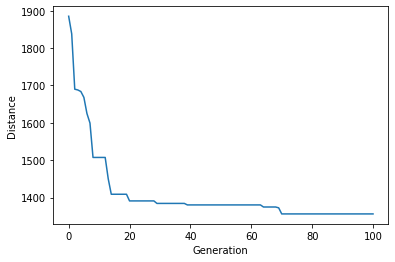

In [470]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=10, mutationRate=0.01, generations=100)